# Investigating Hybrid Strategies for Systematic Literature Review

In [1]:
%matplotlib inline

import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years
from snowballing.strategies import Strategy, State
import custom_strategies
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

custom_strategies.LIMIT_YEAR = 2019
reload()
# !pip install matplotlib-venn

In [2]:
import statistics as s
from collections import Counter, deque
from snowballing.operations import metakey, metakey_title

def busca(*libraries, seed=None, filter_function=None):
    filter_function = filter_function or (lambda x: x.category in ("snowball",))
    if seed is not None:
        iterable = ((1, work_by_varname(x)) for x in seed)
    else:
        iterable = load_work_map_all_years()
    seedset = set()
    visited = set()
    for _, work in iterable:
        for library in libraries:
            if int(getattr(work, library, 0)):
                visited.add(work)
                if filter_function(work):
                    seedset.add(work)
                break
    return seedset, filter_function, visited

def descreve_delta(strategy, state, name):
    target = state.find(name)
    previous_related = reduce(lambda x, y: x | y, (s.related for s in target.previous[0]), set())
    for work in previous_related:
        backward = set(strategy.ref[work]) & target.delta_visited
        if backward:
            print('backward', work.metakey)
            for ref in backward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')
        forward = set(strategy.rev_ref[work]) & target.delta_visited
        if forward:
            print('forward', work.metakey)
            for ref in forward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')

def separa_backward_forward(state):
    backward = set()
    forward = set()
    stack = [state]
    visited = {id(state)}
    while stack:
        current = stack.pop()
        if current.previous:
            if current.previous[1] == "backward":
                backward |= current.delta_related
            if current.previous[1] == "forward":
                forward |= current.delta_related
                
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.append(previous)
    return backward, forward

def encontraria(strategy, state):
    backward = set()
    forward = set()
    related = state.related - state.find("s0").related
    for work in state.related:
        backward |= (set(strategy.ref[work]) & related)
        forward |= (set(strategy.rev_ref[work]) & related)
    return backward, forward

class FinalSelection(State):
    
    def __init__(self, state):
        self.state = state
    
    @property
    def log(self):
        return []
    
    @property
    def dot(self):
        result = ["digraph G {", '  rankdir="RL";', ""]
        actions = Counter()

        stack = deque([self.state])
        visited = {id(self.state)}
        while stack:
            current = stack.popleft()
            current.final_selected = {
                work for work in current.related 
                if int(getattr(work, "final_selected", 0))
            }
            current.seed_set = {
                work for work in current.related 
                if int(getattr(work, "seed_set", 0))
            }
            current.delta_selected = {}
            current.delta_seed_set = {}
            options = [
                (" visited", len(current.visited)),
                (" selected", len(current.related)),  #  ("WorkSnowball", len(current.related)),
                #("selected", len(current.final_selected)),
                #("seed_set", len(current.seed_set)),
            ]
            result.append('  {0} [label="{0}\\n{1}"];'.format(
                current.name, 
                "\\n".join("{}: {}".format(key, value) for key, value in options)
            ))
            if current.previous:
                operation = current.previous[1]
                for element in current.previous[0]:
                    if operation == "union":
                        result.append('  {} -> {} [label="{}"];'.format(
                            current.name, element.name, operation
                        ))
                        
                        
                    else:
                        current.delta_selected = {
                            work for work in current.delta_related 
                            if int(getattr(work, "final_selected", 0))
                        }
                        current.delta_seed_set = {
                            work for work in current.delta_related 
                            if int(getattr(work, "seed_set", 0))
                        }
                        
                        options = [
                            (" visited", len(current.delta_visited)),
                            (" selected", len(current.delta_related)),
                            #("selected", len(current.delta_selected)),
                            #("seed_set", len(current.delta_seed_set)),
                        ]
                        result.append('  {} -> {} [label="{}\\n{}"];'.format(
                            current.name, element.name, operation,
                            "\\n".join("{}: {}".format(key, value) for key, value in options)
                        ))
                    if id(element) not in visited:
                        stack.append(element)
                        visited.add(id(element))
            result.append("")

        result.append("}")
        return '\n'.join(result)


def precision_recall(state, total, final, stop=""):
    # Precisao 0 quando nao visita nada
    array = [[
        "state", "precision", "recall", "fmeasure", 
        "final_precision", "final_recall", "final_fmeasure", 
        "operation", "delta_related", "delta_visited", "delta_selected",
        "related", "visited", "final_selected",
        "accumulated_precision", "accumulated_recall", "accumulated_fmeasure",
        "final_accumulated_precision", "final_accumulated_recall", "final_accumulated_fmeasure"
    ]]
    FinalSelection(state).dot
    stack = deque([state])
    visited = {id(state)}
    while stack:
        current = stack.pop()
        accumulated_recall = len(current.related) / len(total)
        recall = len(current.delta_related) / len(total)
        final_accumulated_recall = len(current.final_selected) / len(final)
        final_recall = len(current.delta_selected) / len(final)
        try:
            accumulated_precision = len(current.related) / len(current.visited)
            precision = len(current.delta_related) / len(current.delta_visited)
        except ZeroDivisionError:
            precision = float('nan')
        try:
            final_accumulated_precision = len(current.final_selected) / len(current.visited)
            final_precision = len(current.delta_selected) / len(current.delta_visited)
        except ZeroDivisionError:
            final_precision = float('nan')
        try:
            accumulated_fmeasure = s.harmonic_mean([accumulated_precision, accumulated_recall])
            fmeasure = s.harmonic_mean([precision, recall])
        except ZeroDivisionError:
            fmeasure = float('nan')
        try:
            final_accumulated_fmeasure = s.harmonic_mean([final_accumulated_precision, final_accumulated_recall])
            final_fmeasure = s.harmonic_mean([final_precision, final_recall])
        except ZeroDivisionError:
            final_fmeasure = float('nan')
            
            
        array.append([
            current.name,
            precision,
            recall,
            fmeasure,
            final_precision,
            final_recall,
            final_fmeasure,
            current.previous[1] if current.previous else "-",
            len(current.delta_related),
            len(current.delta_visited),
            len(current.delta_selected),
            len(current.related),
            len(current.visited),
            len(current.final_selected),
            accumulated_precision,
            accumulated_recall,
            accumulated_fmeasure,
            final_accumulated_precision,
            final_accumulated_recall,
            final_accumulated_fmeasure,
        ])
        if current.name == stop:
            break
        if current.previous:              
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.appendleft(previous)
    return array

# Strategies

## Strategy 1 - Database Search

In [3]:
print ("Total de estudos primários reproduzidos: 11 do Seed Set + 3 encontrados durante o Snowballing = ", len ({x for _, x in load_work_map_all_years() if x.category == "snowball"}))

Total de estudos primários reproduzidos: 11 do Seed Set + 3 encontrados durante o Snowballing =  14


In [4]:
reload()
TOTAL = {x for _, x in load_work_map_all_years() if getattr(x, "seed_set", 0)}
FINAL = {x for _, x in load_work_map_all_years() if getattr(x, "final_selected", 0)}
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2016", filter_function=filter_function)) # busca simples

state = strategy.initial
strategy.initial.visited

FinalSelection(state);

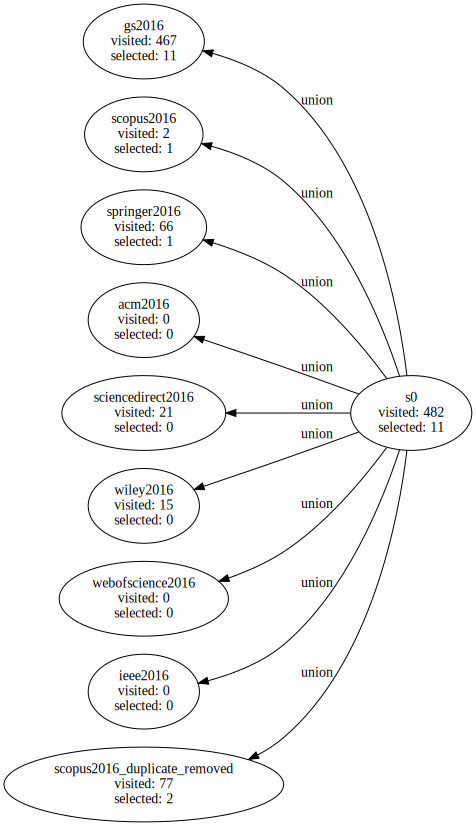

In [5]:
from snowballing.strategies import State

reload()
def busca_completa(libs, filter_function):
    union = None
    for dl in libs:
        strategy = Strategy(*busca(dl, filter_function=filter_function))
        strategy.initial.name = dl
        if union is None:
            union = strategy.initial.derive("union", name="s0") 
        else:
            union.visited.update(strategy.initial.visited)
            union.related.update(strategy.initial.related)
            union.previous[0].append(strategy.initial)

    State.last_id = 0
    strategy.initial = union
    return strategy

strategy = busca_completa(["gs2016", "scopus2016", "springer2016", "acm2016", "sciencedirect2016", "wiley2016", "webofscience2016", "ieee2016", "scopus2016_duplicate_removed"], filter_function)
state = strategy.initial
FinalSelection(strategy.initial)

In [6]:
#strategy.initial.seed_set @ metakey_title
strategy.initial.related

{A CMMI Ontology for An Ontology-Based Software Process Assessment Tool,
 An ontology based infrastructure to support CMMI-based software process assessment,
 A software process ontology and its application,
 A strategic test process improvement approach using an ontological description for MND-TMM,
 Project assets ontology (PAO) to support gap analysis for organization process improvement based on CMMI v. 1.2,
 Building process definition with ontology background,
 Towards automated process assessment in software engineering,
 Representing Software Process in Description Logics: n Ontology pproach for Software Process Reasoning and Verification,
 An ontology-based approach to express software processes,
 Automated software engineering process assessment: supporting diverse models using an ontology,
 A partial formalization of the CMMI-DEV—A capability maturity model for development}

In [7]:
array = []
name = "E1"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df = df.round(4)
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df
                                  


10,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,scopus2016_duplicate_removed,0.026,0.182,0.045,0.0,0.0,0,-,2,77,0,2,77,2,0.026,0.182,0.045,0.026,0.143,0.044
1,ieee2016,NaN,0.000,0.000,NaN,0.0,0,-,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
2,webofscience2016,NaN,0.000,0.000,NaN,0.0,0,-,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
3,wiley2016,0.000,0.000,0.000,0.0,0.0,0,-,0,15,0,0,15,0,0.000,0.000,0.000,0.000,0.000,0.000
4,sciencedirect2016,0.000,0.000,0.000,0.0,0.0,0,-,0,21,0,0,21,0,0.000,0.000,0.000,0.000,0.000,0.000
5,acm2016,NaN,0.000,0.000,NaN,0.0,0,-,0,0,0,0,0,0,0.015,0.000,0.000,0.015,0.000,0.000
6,springer2016,0.015,0.091,0.026,0.0,0.0,0,-,1,66,0,1,66,1,0.015,0.091,0.026,0.015,0.071,0.025
7,scopus2016,0.500,0.091,0.154,0.0,0.0,0,-,1,2,0,1,2,1,0.500,0.091,0.154,0.500,0.071,0.125
8,gs2016,0.024,1.000,0.046,0.0,0.0,0,-,11,467,0,11,467,11,0.024,1.000,0.046,0.024,0.786,0.046
9,s0,NaN,0.000,0.000,NaN,0.0,0,union,0,0,0,11,482,11,0.023,1.000,0.045,0.023,0.786,0.044


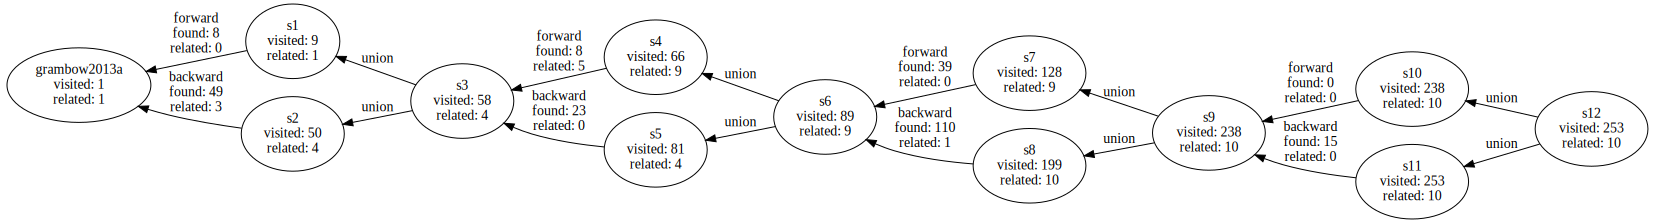

In [20]:
reload()
NAME = "grambow2013a"
filter_function = lambda x: x.category in ("snowball", "forward", "backward")
seedset = {work_by_varname(NAME)}
strategy = Strategy(seedset, filter_function)
strategy.initial.name = NAME
state = strategy.sfbu()
state

## Strategy 2 - Database Search + Snowballing (Guideline Wohlin)

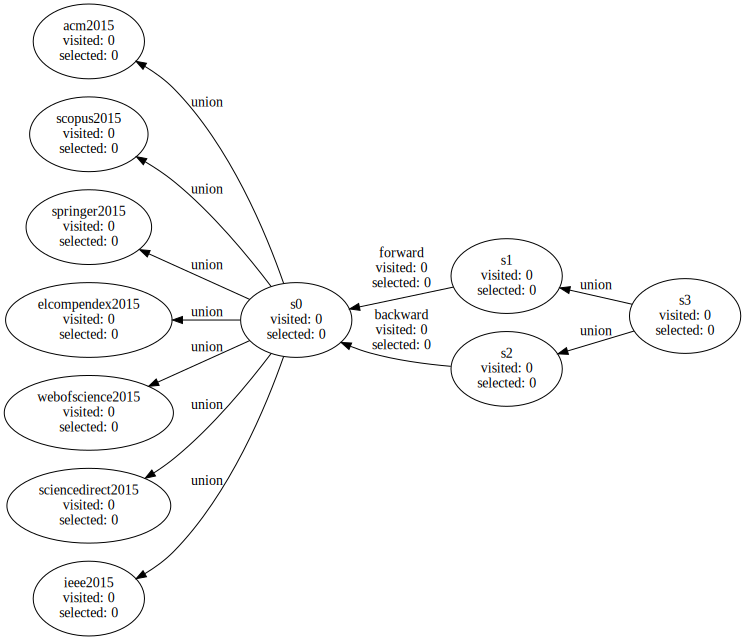

In [9]:
reload()
TOTAL = {x for _, x in load_work_map_all_years() if x.category == "snowball"}
FINAL = {x for _, x in load_work_map_all_years() if getattr(x, "final_selected", 0)}
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = busca_completa(["acm2015", "scopus2015", "springer2015", "elcompendex2015", "webofscience2015", "sciencedirect2015", "ieee2015"], filter_function)
state = strategy.sfbu()

FinalSelection(state)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib_venn\_venn2.py:50: UserWarning: Both circles have zero area
  warnings.warn("Both circles have zero area")


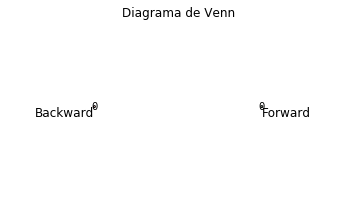

In [10]:
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title('Diagrama de Venn')
plt.show()

In [11]:
#Backward - Execução de backward em sets[0]
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)

Backward []
Forward []


In [ ]:
name = "E2"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))
        
df

In [ ]:
ndf

In [ ]:
#ndf = df.loc[df['operation'] == 'union'].reset_index(drop=True)
fig = plt.figure()
df['precision'].plot(legend=True)
df['recall'].plot(legend=True)
df['fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("By State");
plt.xticks(np.arange(0, len(df), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
plt.tight_layout()

In [ ]:
#ndf = df.loc[df['operation'] == 'union'].reset_index(drop=True)
fig = plt.figure()
df['final_precision'].plot(legend=True)
df['final_recall'].plot(legend=True)
df['final_fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("Final By State");
plt.xticks(np.arange(0, len(df), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
plt.tight_layout()

In [ ]:
# ---- Grafico de linha para Somente Union 

ndf = df.loc[df['operation'] == 'union'].reset_index(drop=True)
fig = plt.figure()
ndf['accumulated_precision'].plot(legend=True)
ndf['accumulated_recall'].plot(legend=True)
ndf['accumulated_fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(ndf["state"] + "\n" + ndf["operation"])
plt.xticks(np.arange(0, len(ndf), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
ax.set_title("Accumulated");
plt.tight_layout()


In [ ]:
ndf = df.loc[df['operation'] == 'union'].reset_index(drop=True)
fig = plt.figure()
ndf['final_accumulated_precision'].plot(legend=True)
ndf['final_accumulated_recall'].plot(legend=True)
ndf['final_accumulated_fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(ndf["state"] + "\n" + ndf["operation"])
plt.xticks(np.arange(0, len(ndf), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
ax.set_title("Final Accumulated");
plt.tight_layout()

## Strategy 3 - Informal Search (Google Scholar) + Snowballing (Guideline Wohlin)

In [ ]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("gs", filter_function=filter_function))
state = strategy.sfbu()
FinalSelection(state)

In [ ]:
name = "E3"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df


## Strategy 4 - Scopus + Snowballing (Guideline Wohlin)

In [ ]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2015", filter_function=filter_function))

state = strategy.sfbu()
FinalSelection(state)

In [ ]:
name = "E4"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df

## Strategy 5 - Scopus + Snowballing (Short Paper)

In [ ]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2015", filter_function=filter_function))
state = strategy.s2bbff2u()
FinalSelection(state)

In [ ]:
name = "E5"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df

## Strategy 6 - Scopus + Snowballing (JF BF)

In [ ]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2015", filter_function=filter_function))
state = strategy.bbff()
FinalSelection(state)

In [ ]:
name = "E6"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df

## Strategy 7 - Scopus + Snowballing (JF FB)

In [ ]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2015", filter_function=filter_function))
state = strategy.ffbb()
FinalSelection(state)

In [ ]:
name = "E7"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df

# Analyses

In [ ]:
%matplotlib inline
import pandas as pd

In [ ]:
df = pd.DataFrame (array,columns = [
    'Estratégia', 'Related', 'Visited', 'Final Selected', 
    'Precision', 'Recall', 'F-Measure',
    'Final Precision', 'Final Recall', 'Final F-Measure'])
df.index = df['Estratégia']
df
print (array)

d_decimals = 2    
for coluna in ['Precision', 'Recall', 'F-Measure', 'Final Precision', 'Final Recall', 'Final F-Measure',]:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df

In [ ]:
import matplotlib.pyplot as plt
exclude = ['Related', 'Visited', 'Final Selected']

ax = df.loc[:, df.columns.difference(exclude)].plot.bar(title ="Precision e Recall das Estratégias")
plt.tight_layout()


In [ ]:
df

d_decimals = 2    
for coluna in ['Precision', 'Recall', 'F-Measure', 'Final Precision', 'Final Recall', 'Final F-Measure',]:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df

In [ ]:
#df.to_csv("estrategias.csv")
df.to_excel("estrategias.xlsx")

In [ ]:
#len ({x for _, x in load_work_map_all_years() if x.category == "snowball"})

In [ ]:
#{x for _, x in load_work_map_all_years() if x.category == "snowball"} @ metakey_title